# Fine-tuning of Pre-trained Models

**Objective:** Fine-tune a pretrained ResNet50 model to classify *Microcoleus anatoxicus* images, including preprocessing pipeline based on fine-tune splits, definition of a pre-trained model, training and evaluation.

## 1. Imports & Utilities

In [1]:
import copy
import math
import os
import subprocess
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import yaml
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import models, datasets
from torchvision.models import ResNet50_Weights
from tqdm import tqdm

from src.config_utils import load_config

config = load_config(path='../configs/config_finetune_resnet50.yaml')

FIG_OUT  = os.path.join('..','outputs','figures', 'Switzerland', 'finetune_resnet50')

device = config['training']['device']

# Generate Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)

Run ID : 2025-07-27_3319866


## 2. Data Preparation

In [2]:
# Define transforms based on config
data_cfg = config['augmentation']
train_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.RandomHorizontalFlip() if data_cfg['horizontal_flip'] else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(data_cfg['rotation']),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

# Create dataset
dataset = datasets.ImageFolder(root=os.path.join( '../', config['data']['path']), transform=train_transform)

# Split into train/val
total = len(dataset)
train_size = int(config['data']['train_split'] * total)
val_size = total - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_set, batch_size=config['data']['batch_size'], shuffle=True, num_workers=config['data']['num_workers'])
val_loader   = DataLoader(val_set,   batch_size=config['data']['batch_size'], shuffle=False, num_workers=config['data']['num_workers'])

## 3. Model Definition

In [3]:
model_cfg = config['model']
model = getattr(models, model_cfg['name'])(weights=ResNet50_Weights.DEFAULT)
if hasattr(model, 'fc'):
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, model_cfg['num_classes'])
elif hasattr(model, 'classifier'):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, model_cfg['num_classes'])
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=float(config['training']['learning_rate']), weight_decay=float(config['training']['weight_decay']))

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(loader, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc  = correct.double() / total
    return epoch_loss, epoch_acc.item()


def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds  = []
    all_probs  = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Val'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            probs  = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc  = correct.double() / total
    return (
        epoch_loss,
        epoch_acc.item(),
        np.array(all_labels),
        np.array(all_preds),
        np.array(all_probs)
    )

# Model summary for verification
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

## 4. Training Loop

In [4]:
# Training and validation loop
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_roc_auc': [],  'val_avg_prec': []
}

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
num_bad_epochs = 0

for epoch in range(config['training']['epochs']):
    print(f"Epoch {epoch+1}/{config['training']['epochs']}")
    t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    v_loss, v_acc, y_true, y_pred, y_prob = eval_model(model, val_loader, criterion, device)
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)
    roc_auc   = roc_auc_score(y_true, y_prob)
    avg_prec  = average_precision_score(y_true, y_prob)
    history['val_roc_auc'].append(roc_auc)
    history['val_avg_prec'].append(avg_prec)

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        num_bad_epochs = 0
    else:
        num_bad_epochs += 1

    if num_bad_epochs >= patience:
        print(f"No improvement for {patience} epochs. Early stopping.")
        break

    print(f"Train loss: {t_loss:.4f}, acc: {t_acc:.4f} | Val loss: {v_loss:.4f}, acc: {v_acc:.4f} | ROC AUC: {roc_auc:.3f}, AP: {avg_prec:.3f}")

model.load_state_dict(best_model_wts)

Epoch 1/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.54s/it]


Train loss: 0.6150, acc: 0.6585 | Val loss: 0.4372, acc: 0.8407 | ROC AUC: 0.923, AP: 0.938
Epoch 2/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.58s/it]


Train loss: 0.3435, acc: 0.8862 | Val loss: 0.2365, acc: 0.9115 | ROC AUC: 0.969, AP: 0.964
Epoch 3/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.53s/it]


Train loss: 0.1835, acc: 0.9353 | Val loss: 0.2505, acc: 0.9115 | ROC AUC: 0.967, AP: 0.961
Epoch 4/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.56s/it]


Train loss: 0.1551, acc: 0.9420 | Val loss: 0.1114, acc: 0.9381 | ROC AUC: 0.993, AP: 0.994
Epoch 5/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.56s/it]


Train loss: 0.1336, acc: 0.9442 | Val loss: 0.1609, acc: 0.9558 | ROC AUC: 0.982, AP: 0.976
Epoch 6/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.56s/it]


Train loss: 0.1037, acc: 0.9643 | Val loss: 0.1257, acc: 0.9381 | ROC AUC: 0.995, AP: 0.995
Epoch 7/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.55s/it]


Train loss: 0.1030, acc: 0.9598 | Val loss: 0.1896, acc: 0.9292 | ROC AUC: 0.981, AP: 0.985
Epoch 8/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.52s/it]


Train loss: 0.0748, acc: 0.9844 | Val loss: 0.1917, acc: 0.9204 | ROC AUC: 0.980, AP: 0.978
Epoch 9/20


Val: 100%|██████████| 8/8 [00:36<00:00,  4.53s/it]

No improvement for 5 epochs. Early stopping.


<All keys matched successfully>

In [5]:
# Save history to logs and checkpoints
os.makedirs('../outputs/logs/Switzerland/finetune_resnet50', exist_ok=True)
hist_path = f"../outputs/logs/Switzerland/finetune_resnet50/history_finetune_resnet50_{run_id}.pkl"
pd.to_pickle(history, hist_path)

os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet50', exist_ok=True)
hist_path = f"../outputs/checkpoints/Switzerland/finetune_resnet50/history_finetune_resnet50_{run_id}.pkl"
pd.to_pickle(history, hist_path)

## 5. Results Visualization

Accuracy curves saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_accuracy_curves.png


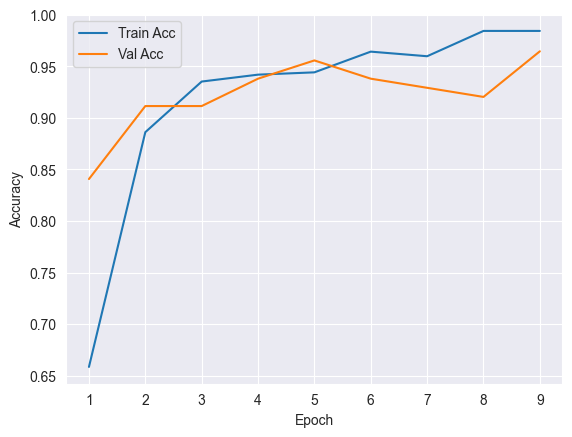

In [15]:
# Plot loss and accuracy curves
epochs = range(1, len(history['train_acc']) + 1)

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save accuracy curves figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_accuracy_curves.png")
plt.savefig(fig_path, dpi=300)
print("Accuracy curves saved at:", fig_path)

plt.show()

Loss curves saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_loss_curves.png


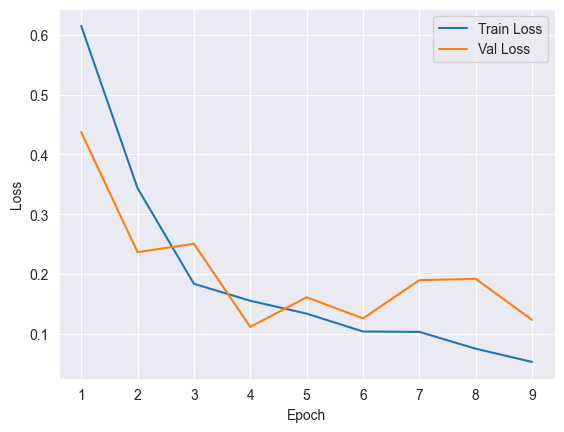

In [16]:
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save loss curves figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_loss_curves.png")
plt.savefig(fig_path, dpi=300)
print("Loss curves saved at:", fig_path)

plt.show()

ROC curve saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_roc_curve.png


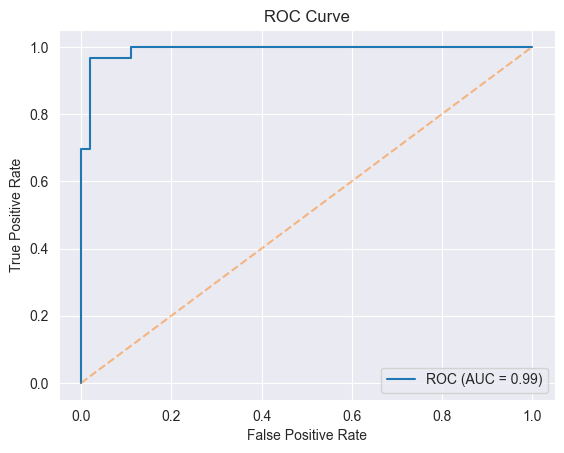

In [17]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
roc_auc_val = roc_auc_score(y_true, y_prob)
ap_val = average_precision_score(y_true, y_prob)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Save ROC figure to:
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"), dpi=300)
print("ROC curve saved at:", os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"))
plt.show()

PR curve saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_pr_curve.png


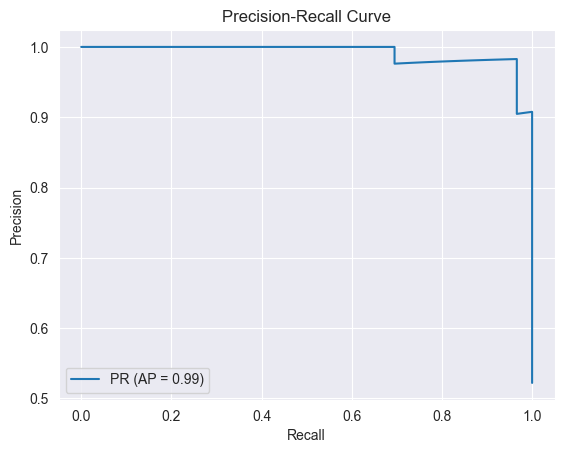

In [18]:
# Plot PR
plt.figure()
plt.plot(recall, precision, label=f'PR (AP = {ap_val:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
print("PR curve saved at:", os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"))

plt.show()

Confusion matrix saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_confusion_matrix.png


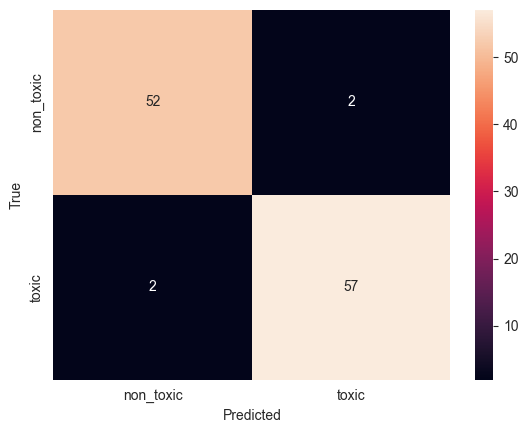

In [19]:
# Confusion matrix
target_names = dataset.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True')
plt.xlabel('Predicted')

# Save confusion matrix figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300)
print("Confusion matrix saved at:", fig_path)

plt.show()

Classification report CSV saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_classification_report.csv
Classification report image saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_classification_report.png


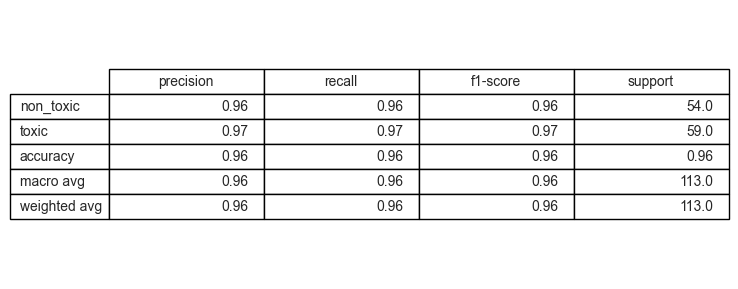

In [20]:
# Classification report
# print(classification_report(y_true, y_pred, target_names=target_names))

report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names, output_dict=True)).T

csv_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.csv")
report_df.to_csv(csv_path, index=True)
print("Classification report CSV saved at:", csv_path)

fig, ax = plt.subplots(figsize=(8, len(report_df) * 0.5 + 1))
ax.axis('off')

table = ax.table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

img_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.png")
fig.savefig(img_path, dpi=300, bbox_inches='tight')
print("Classification report image saved at:", img_path)

## 6. Calibration (Platt Method)

Val: 100%|██████████| 8/8 [00:38<00:00,  4.76s/it]

Brier score (calibrated): 0.0397


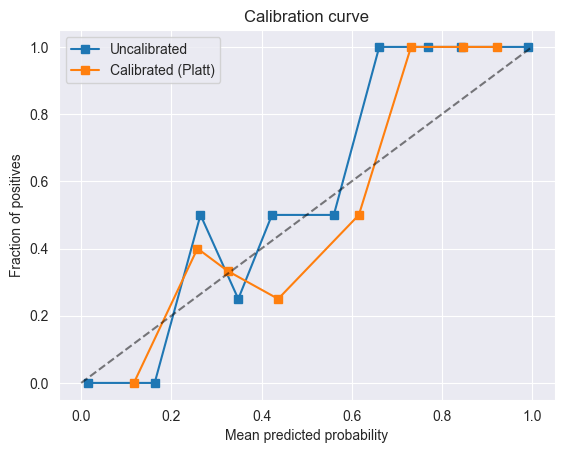

In [21]:
v_loss, v_acc, y_true_val, y_pred_val, y_prob_val = eval_model(
    model, val_loader, criterion, device
)

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            inputs = torch.stack([transforms.ToTensor()(img) for img in X]).to(device)
            outputs = self.model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs

wrapper = ModelWrapper(model)
calibrator = CalibratedClassifierCV(wrapper, cv='prefit', method='sigmoid')

lr_cal = LogisticRegression().fit(
    y_prob_val.reshape(-1,1),
    y_true_val
)

y_prob_cal = lr_cal.predict_proba(y_prob_val.reshape(-1,1))[:,1]

brier = brier_score_loss(y_true_val, y_prob_cal)
print(f"Brier score (calibrated): {brier:.4f}")

frac_pos, mean_pred = calibration_curve(y_true_val, y_prob_val, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_true_val, y_prob_cal, n_bins=10)

plt.figure()
plt.plot(mean_pred,   frac_pos,   's-', label='Uncalibrated')
plt.plot(mean_pred_cal, frac_pos_cal, 's-', label='Calibrated (Platt)')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_calibration_curve.png"), dpi=300)
plt.show()

## 7. Grad-CAM Interpretability

Grad-CAM image saved at: ../outputs/figures/Switzerland/finetune_resnet50/2025-07-27_3319866_grad-cam.png


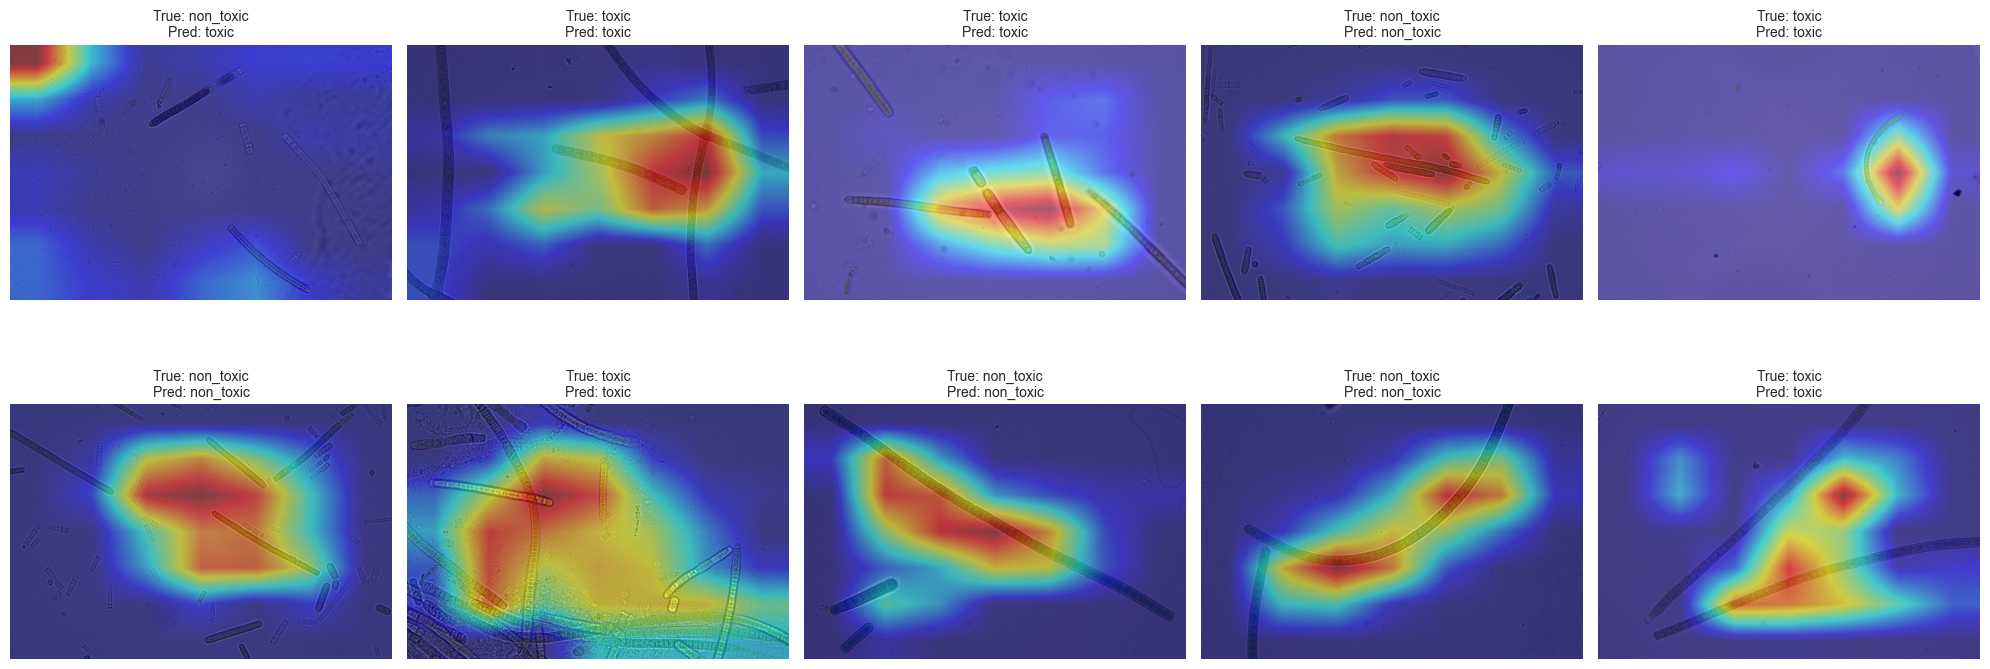

In [22]:
vis_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

target_layer = model.layer4[-1].conv2
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

n_display = 10

n_cols = 5
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 4),
                         dpi=100)
axes = axes.flatten()

for idx in range(n_display):
    ax = axes[idx]

    tensor_aug, true_label = val_set[idx+12]
    orig_path, _ = val_set.dataset.samples[val_set.indices[idx+12]]
    orig_img: Image.Image = Image.open(orig_path).convert('RGB')
    W, H = orig_img.size

    orig_resized = transforms.Resize(tuple(data_cfg['resize']))(orig_img)
    input_tensor = vis_transform(orig_resized).unsqueeze(0)

    outputs = model(input_tensor)
    pred_label = outputs.argmax(dim=1).item()

    grayscale_cam = cam_extractor(input_tensor=input_tensor)[0]

    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((W, H), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img, dtype=np.float32) / 255.0

    rgb_orig = np.array(orig_img, dtype=np.float32) / 255.0
    cam_on_orig = show_cam_on_image(rgb_orig, cam_resized, use_rgb=True)

    ax.imshow(cam_on_orig)
    ax.set_title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}",
                 fontsize=10)
    ax.axis('off')

for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()

fig_path = os.path.join(FIG_OUT, f"{run_id}_grad-cam.png")
plt.savefig(fig_path, dpi=300)
print("Grad-CAM image saved at:", fig_path)

plt.show()

## 8. Save Model & Config

In [23]:
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet50', exist_ok=True)
torch.save(model.state_dict(), f'../outputs/checkpoints/Switzerland/finetune_resnet50/{run_id}_model.pth')

with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet50.yaml', 'w') as f:
    yaml.dump(config, f)

print('Training complete. Model and configuration saved in outputs')

Training complete. Model and configuration saved in outputs
